# Test the loss functions

In [29]:
%reload_ext autoreload
%autoreload 2

In [1]:
# Basic
from IPython.display import display

# For OS-agnostic paths
from pathlib import Path

# Plotting
from matplotlib import pyplot as plt
import seaborn as sns
import torch
from torch import nn
import pandas as pd
import numpy as np
sns.set_style("whitegrid")
from copy import deepcopy
import glob, json
from datetime import datetime
import torch
from torch import nn

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import DataLoader, Dataset, TensorDataset


from torchinfo import summary

%cd ..

from src.utils import load_raw_data
from src.plotting import plot_pointcloud, plot_sample_figures
from src.models.HardSphereGAN import GAN
from src.models.StaticScaler import StaticMinMaxScaler

%cd -

plt.set_cmap("viridis")

/Users/veikko/Documents/GitHub/hard-spheres
/Users/veikko/Documents/GitHub/hard-spheres/Notebooks


<Figure size 640x480 with 0 Axes>

In [2]:

phis = [0.84] # Add more phis here

path = Path("../data/raw/samples")
path = Path("../data/raw/crystal/Hex")
path = Path("../data/raw/crystal/Sq")


files, dataframe, metadata = load_raw_data(path, phi=phis, subpath="disorder-0.2")

dataframe.sort_index()


# Hex lattice

N = 1600 
X_box = 41.076212368516387
Y_box = 35.573043402379753   
 
# Square lattice
N = 1600
X_box = 38.225722823651111
y_box = 38.225722823651111 
dataframe["r"] = 0.375 # Fixed radius for all data in square lattice
# dataframe["r"] = 5.375 # Fixed radius for all data in square lattice


Number of Files found :  100


In [3]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scale_factor = max(X_box, Y_box)
# r_scale_factor = dataframe["r"].max()

scaler = StaticMinMaxScaler(
    columns = ["x", "y", "r"],
    maximum = [scale_factor, scale_factor, 2*scale_factor], # NOTE: Tuned for physical feasibility
    minimum = [-scale_factor, -scale_factor, 0] # NOTE: Tuned for physical feasibility
)

dataframe_scaled = pd.DataFrame(scaler.transform(dataframe.copy()), columns=dataframe.columns)

dataframe_scaled.set_index(dataframe.index, inplace=True)

dataframe_scaled = dataframe_scaled.drop(columns=["class"]) # Redundant with r
# dataframe_scaled = dataframe_scaled.sort_values(by=["experiment", "sample"])
dataframe_scaled.describe().round(7)

,x,y,r
count,160000.000000,160000.000000,160000.000000
mean,0.500041,0.500064,0.004905
std,0.146112,0.146110,0.000000
min,0.247042,0.247042,0.004905
25%,0.373534,0.373531,0.004905
50%,0.500025,0.500002,0.004905
75%,0.626463,0.626472,0.004905
max,0.752958,0.752958,0.004905


Creating Dataset
Descriptor List:  ['phi']
torch.Size([100, 1, 1])
torch.Size([100, 1600, 3])


/Users/veikko/Documents/GitHub/hard-spheres/src/HSDataset.py:33: PerformanceWarning: indexing past lexsort depth may impact performance.
  dataframe.loc[(experiment, sample), :].copy().values,


<Axes: >

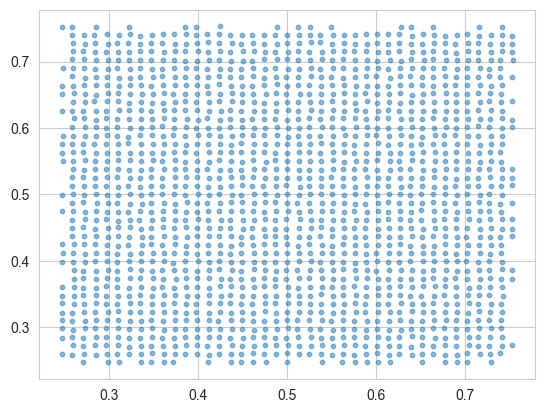

In [4]:
## Build dataset
from src.HSDataset import HSDataset

dataset = HSDataset(
    dataframe_scaled.copy(), # Dont use the ordering
    descriptor_list=["phi"],
    synthetic_samples={"rotational": 0, "shuffling": 0, "spatial_offset_static": 0}, 
    downsample=False
    )
print(dataset[:][0].shape)
print(dataset[:][1].shape)
# Create a function that visualizes the point cloud

plot_pointcloud(dataset[2][1], plot_radius=False)

# Test different components of loss functions

In [5]:
from src.models.losses import HSGeneratorLoss

lfn = HSGeneratorLoss(
    **{
            "radius_loss": 0,
            "grid_density_loss": 1,
            "gan_loss": 1,
            "distance_loss": 1,
            "physical_feasibility_loss": 1,
            "grid_order_loss": 1,
            "coefficients":{
                "gan_loss": 1,
                "radius_loss": 1,
                "grid_density_loss": 50,
                "physical_feasibility_loss": 1,
                "distance_loss": 100,
                "grid_order_loss": 1,
                "grid_order_k":4
            },
        }
)

### Feasibility loss

Creating Dataset
Descriptor List:  ['phi']
Feasibility loss 0.000114369526


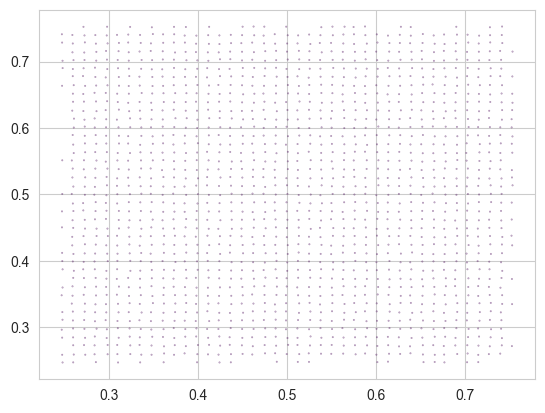

In [6]:

dataset = HSDataset(
    dataframe_scaled.copy(), # Dont use the ordering
    # dataframe.drop("class"),
    descriptor_list=["phi"],
    synthetic_samples={"rotational": 0, "shuffling": 0, "spatial_offset_static": 0}, 
    downsample=False
    )

batch_size = 32

sample_x = dataset.x[0:batch_size]
sample_y = dataset.y[0:batch_size]

plot_pointcloud(sample_y[0], plot_radius=True)

print("Feasibility loss", lfn._physical_feasibility_loss(sample_y).numpy())

The loss is very small, as it should be.



Next set points to overlap on purpose.

Creating Dataset
Descriptor List:  ['phi']
Feasibility loss tensor(0.0001)


tensor(0.0002)

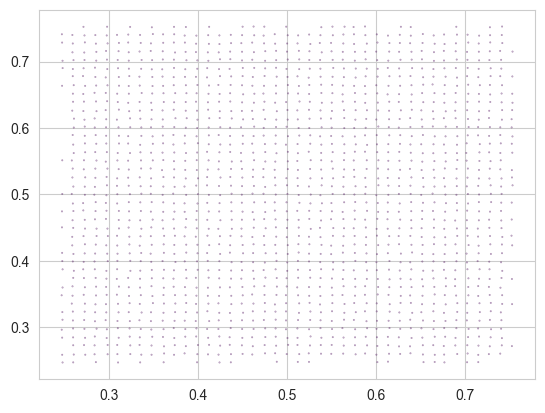

In [7]:
batch_size = 32

dataset = HSDataset(
    dataframe_scaled.copy(), # Dont use the ordering
    # dataframe.drop(columns=["class"]),
    descriptor_list=["phi"],
    synthetic_samples={"rotational": 0, "shuffling": 0, "spatial_offset_static": 0}, 
    downsample=False
    )


sample_x = dataset.x[0:batch_size]
sample_y = dataset.y[0:batch_size]

# Set points to overlap
points = 2

# sample_y[0][:points,0:2] = torch.FloatTensor([1,1])# + torch.randn((points,2))*0.01

plot_pointcloud(sample_y[0], plot_radius=True)

print("Feasibility loss", lfn._physical_feasibility_loss(sample_y))

# Feasibility loss should be zero right?

from torch import cdist

dist = cdist(sample_y[0][:, :2], sample_y[0][:, :2])

# Set the diagonal to zero
dist = dist.tril(diagonal=0) 
dist = dist[~np.isclose(dist, 0)] # Set to some value, we are interested in min and max

dist.min()

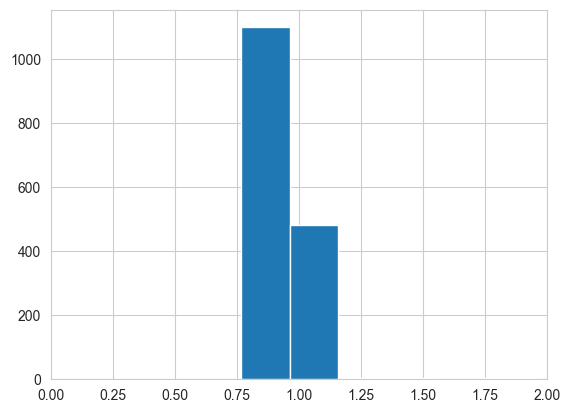

In [8]:
xy = torch.from_numpy(dataframe.query("sample=='sample-78'")[["x","y"]].values)

dist = cdist(xy[:, :2], xy[:, :2])

r_raw = torch.from_numpy(dataframe.query("sample=='sample-78'")[["r"]].values).unsqueeze(0)
# r = (r.T + r)
r = (r_raw.squeeze(0).T + r_raw).squeeze(0)

# Set the diagonal to zero
dist = dist.tril(diagonal=0) 

# Find nearest neighbour
dist[dist <= 1e-5] = torch.inf


plt.hist(dist.min(dim=0).values[:-1], bins=100)
plt.xlim(0,2)
plt.show()
# Smallest distance between two points is 0.5, so our radius should be 0.5
# Anomalies exist closer to zero

Radius 0.33000001311302185: 0.0
Radius 0.4705263078212738: 0.0
Radius 0.6110526323318481: 0.0908290296792984
Radius 0.7515789270401001: 0.18210995197296143
Radius 0.8921052813529968: 0.2715652287006378
Radius 1.0326316356658936: 0.3366732895374298
Radius 1.1731579303741455: 0.38618355989456177
Radius 1.3136842250823975: 0.4251013398170471
Radius 1.4542105197906494: 0.4564977288246155
Radius 1.5947368144989014: 0.4823606610298157
Radius 1.7352631092071533: 0.5040349364280701
Radius 1.8757895231246948: 0.5224615931510925
Radius 2.0163156986236572: 0.5383197665214539
Radius 2.156841993331909: 0.5521115064620972
Radius 2.2973685264587402: 0.5642160177230835
Radius 2.437894821166992: 0.5749251246452332
Radius 2.578421115875244: 0.5844668745994568
Radius 2.718947410583496: 0.5930222272872925
Radius 2.859473705291748: 0.6007367372512817
Radius 3.0: 0.6077286601066589


Distance between 0 and 1 is 1.0
Distance between 0 and 2 is 1.0
Distance between 0 and 3 is 1.4142135381698608
Distance between 1 and 0 is 1.0
Distance between 1 and 2 is 1.4142135381698608
Distance between 1 and 3 is 1.0
Distance between 2 and 0 is 1.0
Distance between 2 and 1 is 1.4142135381698608
Distance between 2 and 3 is 1.0
Distance between 3 and 0 is 1.4142135381698608
Distance between 3 and 1 is 1.0
Distance between 3 and 2 is 1.0


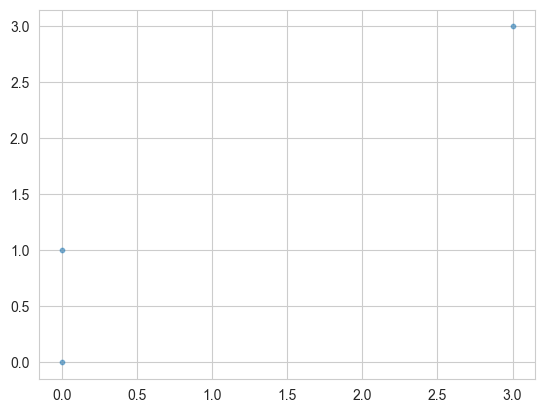

In [9]:
# Try with naive samples

xy = torch.tensor([[0,0], [0,1], [1,0], [1,1]], dtype=torch.float32).unsqueeze(0)
r=2

for r in np.linspace(0.33, 3.0, 20):
    r = r*torch.tensor([1.0, 1.0, 1.0, 1.0], dtype=torch.float32).unsqueeze(0)
    xyr = torch.cat([xy, r.unsqueeze(-1)], dim=-1)
    l = lfn._physical_feasibility_loss(xyr)
    print(f"Radius {r[0,0]}: {l}")

plot_pointcloud(xyr, plot_radius=False)

for i in range(4):
    for j in range(4):
        if i != j:
            print(f"Distance between {i} and {j} is {torch.dist(xyr[0,i,:2], xyr[0,j,:2])}") 


## Test the L1 component

In [10]:
from src.models.losses import HSGeneratorLoss, CryinGANDiscriminatorLoss
from src.models.CryinGAN import CCCGDiscriminator

sample_x = dataset.x[0:batch_size]
sample_y = dataset.y[0:batch_size]

offset_x = 1
offset_y = 1

sample_y_offset = sample_y.clone()
sample_y_offset[:, :, 0:2] = sample_y_offset[:, :, 0:2] + torch.FloatTensor([[offset_x, offset_y]])


input_channels = sample_y.shape[-1] # For fractional coordinates
in_samples = sample_y.shape[1] # For fractional coordinates
disc = CCCGDiscriminator(input_channels=input_channels, in_samples=in_samples)

l_fn = CryinGANDiscriminatorLoss(mu=10)

l_fn.gradient_penalty(real_images=sample_y, fake_images=sample_y_offset, discriminator=disc)


tensor(9.9920, grad_fn=<MulBackward0>)

## Test the nearest neighbors loss

In [11]:
l_fn = HSGeneratorLoss(
    **{
            "radius_loss": 0,
            "grid_density_loss": 1,
            "gan_loss": 1,
            "distance_loss": 1,
            "physical_feasibility_loss": 1,
            "grid_order_loss": 1,
            "coefficients":{
                "gan_loss": 1,
                "radius_loss": 1,
                "grid_density_loss": 50,
                "physical_feasibility_loss": 100,
                "distance_loss": 100,
                "grid_order_loss": 1,
                "grid_order_k":4
            },
        }
)
from pynndescent import NNDescent
from torch.nn import BCELoss, MSELoss  # Enable by default

def _nn_distance_loss(self, real_images, fake_images):
    # Compute k-nearest neighbors distances for both real and fake images
    k = 2  # Number of nearest neighbors
    quantiles = torch.tensor(
        [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        dtype=torch.float32,
        device=fake_images.device,
    )

    # Shape: [batch_size, N, 3]

    real_distances = torch.cdist(real_images[:,:,:2], real_images[:, :, :2], p=2)
    fake_distances = torch.cdist(fake_images[:, :, :2], fake_images[:, :, :2], p=2)
    
    # Shape: [batch_size, N, N]
    # Take N nearest neighbors
    real_distances = torch.topk(real_distances, k=k, dim=2, largest=False).values
    fake_distances = torch.topk(fake_distances, k=k, dim=2, largest=False).values

    # Shape: [batch_size, k, N]

    # Flatten
    real_distances = real_distances.view(real_distances.shape[0], -1)
    fake_distances = fake_distances.view(fake_distances.shape[0], -1)

    real_yq = torch.quantile(real_distances, quantiles, dim=1)
    fake_rq = torch.quantile(fake_distances, quantiles, dim=1)

    loss = MSELoss()(fake_rq, real_yq)
    return loss

offset_x = 100
offset_y = 100

for offset_x in np.linspace(0, 1, 10):
    sample_y_offset = sample_y.clone()
    sample_y_offset[:, :, 0:2] = sample_y_offset[:, :, 0:2] + torch.FloatTensor([[offset_x, offset_x]])
    print(offset_x, 1e8*_nn_distance_loss(1, sample_y, sample_y_offset))


_nn_distance_loss(1, sample_y, sample_y_offset)

0.0 tensor(0.)
0.1111111111111111 tensor(0.0039)
0.2222222222222222 tensor(0.0041)
0.3333333333333333 tensor(0.1280)
0.4444444444444444 tensor(0.1270)
0.5555555555555556 tensor(0.1265)
0.6666666666666666 tensor(0.1292)
0.7777777777777777 tensor(0.6844)
0.8888888888888888 tensor(0.6810)
1.0 tensor(0.6604)


tensor(6.6037e-09)

<Axes: >

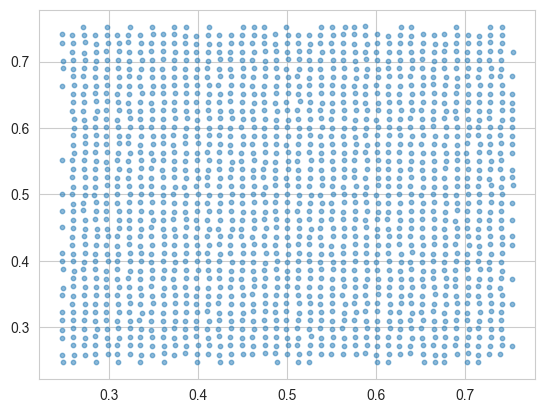

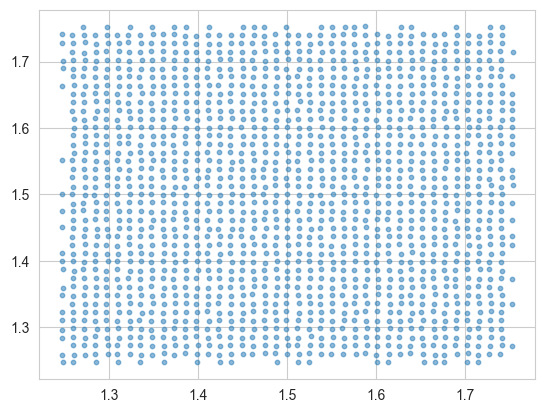

In [12]:
plot_pointcloud(sample_y[0], plot_radius=False)
plot_pointcloud(sample_y_offset[0], plot_radius=False)

In [13]:
torch.normal

<function torch._VariableFunctionsClass.normal>

0.01 tensor(1.1609e-05)
2.5075 tensor(0.0518)
5.005 tensor(0.2073)
7.5024999999999995 tensor(0.4753)
10.0 tensor(0.8538)


Text(0, 0.5, 'Loss')

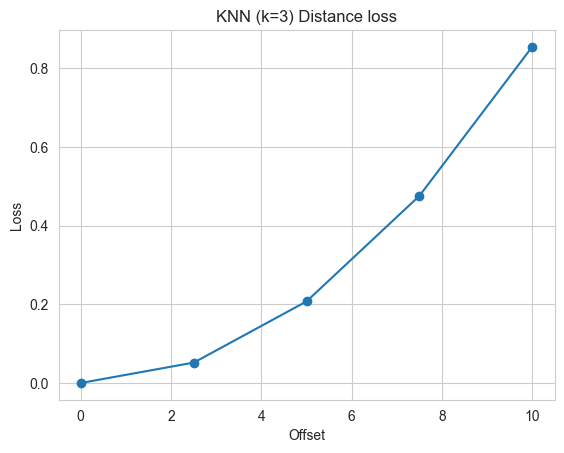

In [14]:
# Test the default distance loss

l = []
offset_xs = np.linspace(0.01, 10, 5)
k = 3

for offset_x in offset_xs:
    sample_y_offset = sample_y.clone()
    sample_y_offset[:, :, 0:2] = sample_y_offset[:, :, 0:2] + torch.normal(mean=1, std=offset_x, size=sample_y_offset[:, :, 0:2].shape)

    res = l_fn._distance_loss(sample_y, sample_y_offset,k=k)
    print(offset_x, res)
    l.append(res)


plt.plot(offset_xs, l, marker="o", linestyle="-")
plt.title(f"KNN (k={k}) Distance loss")
plt.xlabel("Offset")
plt.ylabel("Loss")


In [15]:
dist = cdist(sample_y, sample_y)

print(dist.shape)
dist = torch.topk(dist, k=4, dim=2).values
print(dist.shape)
dist = dist.reshape(dist.shape[0], -1)

print(dist.shape)
print(torch.quantile(dist, torch.tensor([0.1, 0.5, 0.9]), dim=1).transpose(-1,-2).shape)



nn.MSELoss()(torch.quantile(dist, torch.tensor([0.1, 0.5, 0.9]), dim=1), torch.quantile(dist, torch.tensor([0.1, 0.5, 0.9]), dim=1))

torch.Size([32, 1600, 1600])
torch.Size([32, 1600, 4])
torch.Size([32, 6400])
torch.Size([32, 3])


tensor(0.)

## Test angle loss


In [16]:
xy = sample_y[0][:, :2].clone()
xy

tensor([[0.5004, 0.5007],
        [0.5130, 0.4992],
        [0.5265, 0.4999],
        ...,
        [0.4631, 0.4882],
        [0.4753, 0.4883],
        [0.4861, 0.4881]])

Hexatic order parameters for each point:
tensor([ 0.9000-3.5047e-07j,  0.2250-7.5498e-08j,  0.9000-1.9311e-07j,
         0.2250-1.5060e-07j, -0.2000-1.2080e-07j,  0.2250-1.5139e-07j,
         0.9000-7.8681e-08j,  0.2250+0.0000e+00j,  0.9000+7.8681e-08j])


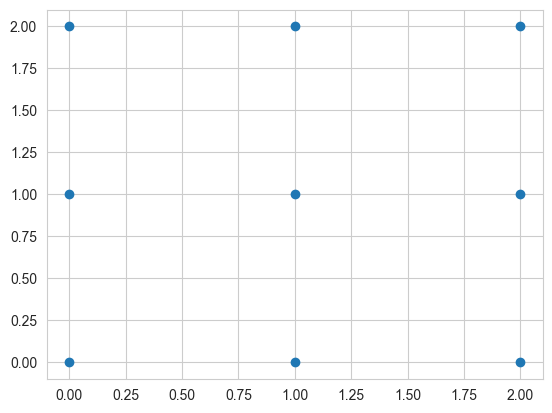

In [17]:
import torch

def hexatic_order_parameter(coords, k=4):# 6 for hex lattice, 4 for the square lattice
    """
    Computes the hexatic order parameter for each point i, i.e.
        Psi(r_i) = (1 / N_i) * sum over j of exp(i * 6 * theta_{ij}),
    where theta_{ij} is the angle of the vector from point i to point j.

    Args:
        coords (torch.Tensor): Shape (N,2) containing the (x,y) positions of N points.

    Returns:
        torch.Tensor: Shape (N,) of complex values for the hexatic order parameter.
    """
    # Ensure coords is shape (N, 2)
    assert coords.dim() == 2 and coords.size(1) == 2, \
        "coords must be of shape (N,2)."
    
    # Number of points
    N = coords.size(0)

    # 1) Compute pairwise differences: shape (N, N, 2)
    #    diffs[i, j, :] = coords[j] - coords[i]
    #    (the vector from i to j)
    diffs = coords.unsqueeze(1) - coords.unsqueeze(0)

    # 2) Compute the angles for each pair using atan2(y, x).
    #    angles[i, j] = angle of vector from i to j
    angles = torch.atan2(diffs[..., 1], diffs[..., 0])  # shape (N, N)

    # 3) Compute exp(i * 6 * theta_{ij}).
    #    We can leverage PyTorch's complex support:
    # e_i6theta = torch.exp(1j * 6 * angles) # 6 in the hex lattice
    e_i6theta = torch.exp(1j * k * angles) # Replaced with 4 in the square lattice

    # 4a) Typically, we do not include the j = i term in the sum (angle to itself).
    #    So we set the diagonal elements to zero.
    # diag_idx = torch.arange(N)
    # e_i6theta[diag_idx, diag_idx] = 0.0 + 0.0j
    
    # 4b) we want to ignore everything except the n nearest neighbors

    distances = torch.cdist(coords, coords, p=2)
    # Set the diagonal to inf as that is the distance to itself and we want to ignore that
    diag_idx = torch.arange(N)
    distances[diag_idx, diag_idx] = torch.inf
    distances_topk = torch.topk(distances, dim=1, k=k, largest=False).values.max(dim=1).values
    mask = distances > distances_topk # This takes in the top k distances and sets everything else to zero
    e_i6theta[mask] = 0.0 + 0.0j
    # 5) Define Ni as the number of neighbors for each point i.
    # Count the number of neighbours per point from the mask

    Ni = mask.shape[0]-mask.sum(dim=1)  # Ni = k
    # Ni = k

    # 6) Sum over j for each i and normalize by Ni.
    #    psi[i] = (1/Ni) * sum_{j != i} exp(i 6 theta_{ij})
    # psi = e_i6theta.sum(dim=1) / Ni
    psi = (e_i6theta / Ni).sum(dim=1)
    
    return psi

# Suppose we have 5 points
coords_example = torch.tensor([
    [0.0, 0.0],
    [1.0, 0.0],
    [0.5, 0.5],
    [1.0, 1.0],
    [2.0, 1.0],
], dtype=torch.float) 

# Test with a square lattice

coords_square_lattice = torch.tensor(
    [
        [x,y] for x in range(0, 3)
        for y in range(0, 3)
    ]
, dtype=torch.float)# + torch.randn((9,2)) * 0.3
# psi_values = hexatic_order_parameter(coords_example)
psi_values = hexatic_order_parameter(coords_square_lattice, k=4)
print("Hexatic order parameters for each point:")

torch.cat([coords_square_lattice, psi_values.unsqueeze(-1)], dim=-1)

plt.scatter(coords_square_lattice[:,0], coords_square_lattice[:,1])

print(psi_values)

Add batch dimension and try again

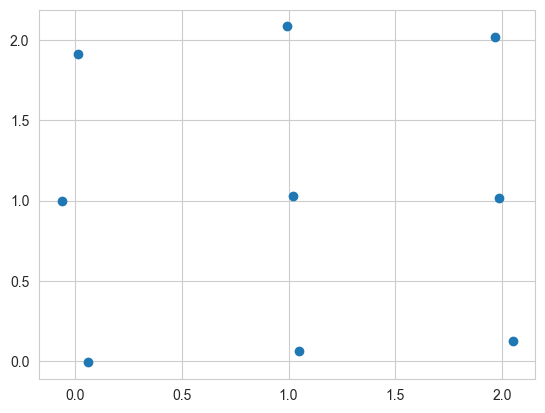

In [18]:
batch = 1

coords_square_lattice_batched = torch.tensor([
    [
        [x,y] for x in range(0, 3)
        for y in range(0, 3)
    ]
    for z in range(0,batch)]
, dtype=torch.float) + 0.05*torch.randn(batch, 9, 2)

plt.scatter(coords_square_lattice_batched[0, :,0], coords_square_lattice_batched[0, :,1])

In [19]:
k=4

In [20]:

coords = coords_square_lattice_batched.clone()


def hexatic_order_parameter_batched(coords, k=4):

    # Ensure coords is shape (N, 2)
    assert coords.dim() == 3 and coords.size(2) == 2, \
        "coords must be of shape (B,N,2)."
    
    # Number of points
    N = coords.size(1)

    # 1) Compute pairwise differences: shape (N, N, 2)
    #    diffs[i, j, :] = coords[j] - coords[i]
    #    (the vector from i to j)
    diffs = coords.unsqueeze(2) - coords.unsqueeze(1)

    # 2) Compute the angles for each pair using atan2(y, x).
    #    angles[i, j] = angle of vector from i to j
    angles = torch.atan2(diffs[..., 1], diffs[..., 0])  # shape (N, N)

    # 3) Compute exp(i * 6 * theta_{ij}).
    #    We can leverage PyTorch's complex support:
    # e_i6theta = torch.exp(1j * 6 * angles) # 6 in the hex lattice
    e_i6theta = torch.exp(1j * k * angles) # Replaced with 4 in the square lattice

    # 4a) Typically, we do not include the j = i term in the sum (angle to itself).
    #    So we set the diagonal elements to zero.
    # diag_idx = torch.arange(N)
    # e_i6theta[diag_idx, diag_idx] = 0.0 + 0.0j

    # 4b) we want to ignore everything except the n nearest neighbors

    distances = torch.cdist(coords, coords, p=2)
    # Set the diagonal to inf as that is the distance to itself and we want to ignore that
    diag_idx = torch.arange(N)
    distances[:, diag_idx, diag_idx] = torch.inf
    distances_topk = torch.topk(distances, dim=1, k=k, largest=False).values.max(dim=1).values
    mask = (distances.transpose(0,1) > distances_topk).transpose(0,1) # This takes in the top k distances and sets everything else to zero
    e_i6theta[mask] = 0.0 + 0.0j # NOTE : This works
    # e_i6theta = torch.where(mask, e_i6theta, torch.ones_like(e_i6theta)*(0.0 + 0.0j)) # NOTE: This maybe does not work

    # 5) Define Ni as the number of neighbors for each point i.
    # Count the number of neighbours per point from the mask

    Ni = mask.shape[1]-mask.sum(dim=2).unsqueeze(-2) # Ni = k
    # Ni = k
    # 6) Sum over j for each i and normalize by Ni.
    #    psi[i] = (1/Ni) * sum_{j != i} exp(i 6 theta_{ij})
    # psi = e_i6theta.sum(dim=1) / Ni
    psi = (e_i6theta / Ni).sum(dim=2)

    return psi

psi_values_batched = hexatic_order_parameter_batched(coords_square_lattice_batched, k=4)

psi_values_batched[0] == psi_values
print(psi_values_batched)
torch.mean(torch.sqrt(psi_values_batched * psi_values_batched.conj())).real

tensor([[ 0.8172+0.2479j,  0.7333+0.0665j,  0.9044+0.1397j,  0.2547+0.0663j,
         -0.2458-0.1592j,  0.7021+0.1366j,  0.7140+0.1629j,  0.2470+0.1511j,
          0.8490-0.0212j]])


tensor(0.6276)

tensor([0.5000-1.9471e-07j, 0.6429-4.8534e-08j, 1.2500-2.7812e-08j,
         ..., 1.2500-7.2852e-08j, 0.6429-2.1856e-08j,
        0.5000+4.3711e-08j])

tensor([0.5000-1.9471e-07j, 0.6429-4.8534e-08j, 1.2500-2.7812e-08j,
         ..., 1.2500-7.2852e-08j, 0.6429-2.1856e-08j,
        0.5000+4.3711e-08j])

tensor([0.4289+9.7422e-07j, 0.4826-7.3806e-04j, 0.4841-1.2368e-06j,
         ..., 0.4841-1.0876e-06j, 0.4826-7.3792e-04j,
        0.4289-1.1982e-06j])

tensor(0.9213)


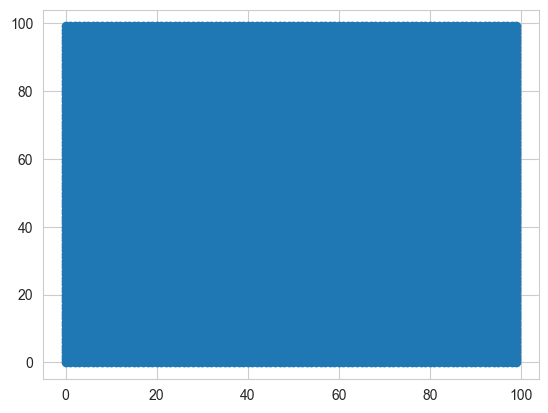

In [73]:
import torch

@staticmethod
def hexatic_order_parameter_fixed(coords, k, sigma=None, eps=1e-6):
    """
    Computes the local hexatic order parameter for each point in a batch,
    with additional numerical stabilization to avoid exploding gradients.

    Args:
        coords: Tensor of shape (B, N, 2), where B is the batch size and N is the number of points.
        k:      Number of nearest neighbors used to define the kth-distance threshold.
                (For a hexatic order parameter, k is typically 6.)
        sigma:  Softness parameter for the sigmoid weighting. If None, it is set to 0.1 times the kth distance.
        eps:    A small constant to prevent numerical instabilities.

    Returns:
        psi:    Tensor of shape (B, N) containing a complex number (the order parameter)
                for each point.
    """
    B, N, _ = coords.shape

    # 1. Compute pairwise differences: shape (B, N, N, 2)
    diffs = coords.unsqueeze(2) - coords.unsqueeze(1)
    
    # 2. Stabilize the x-component: if nearly zero, add eps.
    diff_x = diffs[..., 0]
    # Create a mask where diff_x is too small (absolute value below eps)
    near_zero = diff_x.abs() < eps
    diff_x = diff_x + eps * near_zero.float()  # add eps where needed
    
    # 3. Compute angles using the stabilized x-component: shape (B, N, N)
    angles = torch.atan2(diffs[..., 1], diff_x)
    
    # 4. Compute exp(i * k * theta) for each pair: shape (B, N, N)
    e_iktheta = torch.exp(1j * k * angles)
    
    # 5. Compute pairwise distances manually (Euclidean) with eps for stability
    distances = torch.sqrt(((coords.unsqueeze(2) - coords.unsqueeze(1)) ** 2).sum(-1) + eps)
    
    # Set self-distances to infinity so that a point is never its own neighbor.
    diag_mask = torch.eye(N, dtype=torch.bool, device=coords.device).unsqueeze(0).expand(B, N, N)
    distances = distances.masked_fill(diag_mask, float('inf'))
    
    # 6. For each point, compute the kth smallest distance (neighbor threshold)
    kth_distance = torch.topk(distances, k, dim=2, largest=False).values[..., -1].detach()  # shape (B, N)
    
    # 7. Define sigma if not provided, and ensure sigma is not too small.
    if sigma is None:
        sigma = 0.1 * kth_distance.unsqueeze(-1).clamp(min=eps)  # shape (B, N, 1)
    else:
        sigma = sigma * torch.ones_like(kth_distance.unsqueeze(-1))
    sigma = sigma.clamp(min=eps)
    
    # 8. Compute soft weights for neighbor contributions:
    #    Use the sigmoid on a clamped argument to avoid overflow.
    arg = (kth_distance.unsqueeze(-1) - distances) / sigma
    arg = arg.clamp(min=-50, max=50)  # avoid extremely large exponents
    weights = torch.sigmoid(arg)      # shape (B, N, N)
    
    # 9. Compute a weighted sum and normalize by the sum of weights.
    weighted_sum = (e_iktheta * weights).sum(dim=2)  # shape (B, N)
    weights_sum = weights.sum(dim=2).clamp(min=eps)    # shape (B, N)
    psi = weighted_sum / weights_sum

    return psi


@staticmethod
def hexatic_order_parameter_softmax(coords, k, temperature=1.0, eps=1e-6): # NOTE: Not used, but could be useful for comparison
    """
    Computes the local hexatic order parameter for each point using softmax-based
    weighting of all neighbors. This avoids any non-differentiable operations.

    Args:
        coords: Tensor of shape (B, N, 2).
        k:      (Unused here) Can be kept for compatibility, but the weighting uses softmax over all neighbors.
        temperature: Controls the sharpness of the softmax weighting (lower = sharper).
        eps:    A small constant for numerical stability.

    Returns:
        psi:    Tensor of shape (B, N) containing a complex order parameter per point.
    """
    B, N, _ = coords.shape

    # Compute pairwise differences and angles.
    diffs = coords.unsqueeze(2) - coords.unsqueeze(1)
    diff_x = diffs[..., 0]
    near_zero = diff_x.abs() < eps
    diff_x = diff_x + eps * near_zero.float()
    angles = torch.atan2(diffs[..., 1], diff_x)
    e_iktheta = torch.exp(1j * 6 * angles)  # assuming hexatic order with 6-fold symmetry

    # Compute pairwise distances manually.
    distances = torch.sqrt(((coords.unsqueeze(2) - coords.unsqueeze(1)) ** 2).sum(-1) + eps)
    
    # Set self-distances to a large value to exclude self from weighting.
    diag_mask = torch.eye(N, dtype=torch.bool, device=coords.device).unsqueeze(0).expand(B, N, N)
    distances = distances.masked_fill(diag_mask, float('inf'))
    
    # Use softmax weighting over the negative distances.
    weights = torch.softmax(-distances / temperature, dim=2)  # shape (B, N, N)
    
    # Compute the weighted sum and normalize.
    weighted_sum = (e_iktheta * weights).sum(dim=2)
    # weights sum to 1 by construction (softmax), so no need to normalize further.
    psi = weighted_sum

    return psi

batch=1
lattice_size = 100
coords_square_lattice_batched = torch.tensor([
    [
        [x,y] for x in range(0, lattice_size)
        for y in range(0, lattice_size)
    ]
    for z in range(0,batch)]
, dtype=torch.float) #+ 0.3*torch.randn(batch, 9, 2)

# coords_square_lattice_batched[0][4] = torch.tensor([0.5, 0.5])

plt.scatter(coords_square_lattice_batched[0, :,0], coords_square_lattice_batched[0, :,1])

# Test with a random batch instead

psi_values_orig = hexatic_order_parameter(coords_square_lattice_batched[0], k=4)
psi_values_orig2 = hexatic_order_parameter_batched(coords_square_lattice_batched, k=4)
psi_values = hexatic_order_parameter_fixed(coords_square_lattice_batched, k=4, sigma=None)

print(psi_values_orig.flatten())
print()
print(psi_values_orig2.flatten())
print()
print(psi_values.flatten())
print()

# print(torch.mean(torch.sqrt(psi_values_orig * psi_values_orig.conj())).real)
# print(torch.mean(torch.sqrt(psi_values_orig2 * psi_values_orig2.conj())).real)
print(torch.mean(torch.sqrt(psi_values * psi_values.conj())).real)

tensor([1., 1.])

In [22]:
print(psi_values.real.sort().values)

print(psi_values_batched[0].real.sort().values)


torch.sqrt(psi_values * psi_values.conj()).real.sort().values.mean()

tensor(0.5082)
tensor([-0.2458,  0.2470,  0.2547,  0.7021,  0.7140,  0.7333,  0.8172,  0.8490,
         0.9044])


tensor(0.5082)

In [23]:
def hexatic_order_parameter_loss(samples: torch.Tensor, k=4):

    if len(samples.shape) > 2: # Batched input
        # psi_values = hexatic_order_parameter_batched(coords, k=k)
        psi_values = hexatic_order_parameter_fixed(coords, k=k)
    elif len(samples.shape) == 2:
        xy = samples[:, :2].clone()
        # Compute the hexatic order parameter
        psi_values = hexatic_order_parameter(xy, k=k)

    else:
        raise ValueError("Unrecognnized dimension of input <2, >3")

    # Compute the loss
    loss = torch.mean(torch.sqrt(psi_values * psi_values.conj())).real # The imaginary part is already zero

    return loss
# Compute the loss
loss = hexatic_order_parameter_loss(coords_square_lattice,k=4)
loss_batched = hexatic_order_parameter_loss(coords_square_lattice_batched, k=4)
print("Hexatic order parameter loss:", loss)
print("Hexatic order parameter loss:", loss_batched)

Hexatic order parameter loss: tensor(0.5222)
Hexatic order parameter loss: tensor(0.5105)


## Test the packing fraction metric

In [24]:
sample_y[0].shape

torch.Size([1600, 3])

In [25]:
from src.metrics import packing_fraction_pixel, packing_fraction_pixel_memory_friendly

packing_fraction_pixel(sample_y[:], total_area=torch.tensor([1]), r_fix=0.1, return_grid=False, resolution=32)

tensor([0.4600, 0.4600, 0.4609, 0.4600, 0.4590, 0.4580, 0.4590, 0.4590, 0.4600,
        0.4609, 0.4590, 0.4600, 0.4600, 0.4590, 0.4580, 0.4580, 0.4590, 0.4600,
        0.4590, 0.4590, 0.4590, 0.4580, 0.4590, 0.4590, 0.4590, 0.4600, 0.4590,
        0.4600, 0.4600, 0.4590, 0.4609, 0.4600])

In [26]:
# We know that the packing fraction is 0.84

# plot_pointcloud(sample_y[0],plot_radius=True)

for r_candidate in np.linspace(0.2, 0.25, 20):
    print(f"Radius {r_candidate}: {packing_fraction_pixel(sample_y[0], total_area=torch.tensor([1]), r_fix=r_candidate, return_grid=False, resolution=128)}")

Radius 0.2: tensor([0.7589])
Radius 0.20263157894736844: tensor([0.7763])
Radius 0.20526315789473684: tensor([0.7794])
Radius 0.20789473684210527: tensor([0.7842])
Radius 0.2105263157894737: tensor([0.8013])
Radius 0.2131578947368421: tensor([0.8052])
Radius 0.21578947368421053: tensor([0.8102])
Radius 0.21842105263157896: tensor([0.8270])
Radius 0.2210526315789474: tensor([0.8312])
Radius 0.2236842105263158: tensor([0.8364])
Radius 0.22631578947368422: tensor([0.8533])
Radius 0.22894736842105262: tensor([0.8574])
Radius 0.23157894736842105: tensor([0.8633])
Radius 0.23421052631578948: tensor([0.8801])
Radius 0.2368421052631579: tensor([0.8843])
Radius 0.2394736842105263: tensor([0.8903])
Radius 0.24210526315789474: tensor([0.9075])
Radius 0.24473684210526317: tensor([0.9114])
Radius 0.24736842105263157: tensor([0.9182])
Radius 0.25: tensor([0.9346])


In [27]:
sample_y[0].max(dim=1)

torch.return_types.max(
values=tensor([0.5007, 0.5130, 0.5265,  ..., 0.4882, 0.4883, 0.4881]),
indices=tensor([1, 0, 0,  ..., 1, 1, 1]))

In [28]:
# We know that the packing fraction is 0.84

# plot_pointcloud(sample_y[0],plot_radius=True)

for r_candidate in np.linspace(0.2, 0.25, 30):
    print(f"Radius {r_candidate}: {packing_fraction_pixel(sample_y[0], total_area=1, r_fix=r_candidate, return_grid=False, resolution=1028)}")

Radius 0.2: tensor([0.7745])
Radius 0.2017241379310345: tensor([0.7800])
Radius 0.20344827586206898: tensor([0.7856])
Radius 0.20517241379310347: tensor([0.7912])
Radius 0.20689655172413793: tensor([0.7969])
Radius 0.20862068965517241: tensor([0.8026])
Radius 0.2103448275862069: tensor([0.8083])
Radius 0.2120689655172414: tensor([0.8140])
Radius 0.21379310344827587: tensor([0.8197])
Radius 0.21551724137931036: tensor([0.8255])
Radius 0.21724137931034485: tensor([0.8312])
Radius 0.2189655172413793: tensor([0.8370])
Radius 0.2206896551724138: tensor([0.8428])
Radius 0.22241379310344828: tensor([0.8487])
Radius 0.22413793103448276: tensor([0.8544])
Radius 0.22586206896551725: tensor([0.8603])
Radius 0.22758620689655173: tensor([0.8661])
Radius 0.22931034482758622: tensor([0.8721])
Radius 0.2310344827586207: tensor([0.8780])
Radius 0.23275862068965517: tensor([0.8839])
Radius 0.23448275862068965: tensor([0.8898])
Radius 0.23620689655172414: tensor([0.8958])
Radius 0.23793103448275862: tens